In [1]:
# import os
# os.system("pip install --upgrade pip")
# os.system("python3.8 -m pip install --upgrade pip")
# os.system("pip install --extra-index-url=https://pypi.celonis.cloud/ pycelonis --upgrade")
# os.system("pip install pycelonis")

In [2]:
from pycelonis import *
from pycelonis.pql import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [3]:
url = "https://academic-if21b054-technikum-wien-at.eu-2.celonis.cloud/"

# file = open('./Machine_Learning/APP_KEY.txt')
file = open('APP_KEY.txt')
api_token = file.read()
file.close()

key_type = "APP_KEY"
celonis = get_celonis(base_url=url, api_token=api_token, key_type=key_type, permissions=False)

[2023-06-05 12:16:18,278] WARNING: Your PyCelonis Version 2.0.3 is outdated (Newest Version: 2.2.0). Please upgrade the package via: pip install --extra-index-url=https://pypi.celonis.cloud/ pycelonis pycelonis_core --upgrade


[2023-06-05 12:16:18,376] INFO: Initial connect successful! PyCelonis Version: 2.0.3


In [4]:
data_pool_name = "datapool-filtered-final-version"
data_model_name = "datamodel-filtered-final-version"
activity_table_name = "activities"
rating_table_name = "rating"

In [5]:
data_pool = celonis.data_integration.get_data_pools().find(data_pool_name)
data_model = data_pool.get_data_models().find(data_model_name)
activity_table = data_model.get_tables().find(activity_table_name)
rating_table = data_model.get_tables().find(rating_table_name)

In [6]:
query = PQL(distinct=False, limit=None, offset=None)
query += PQLColumn(name="Zeit", query=""" "ACTIVITIES"."zeit" """)
query += PQLColumn(name="Vollständiger Name", query=""" "ACTIVITIES"."Vollständiger Name" """)
query += PQLColumn(name="Ereigniskontext - Ereignisname", query=""" "ACTIVITIES"."Ereigniskontext - Ereignisname" """)

activity_df = data_model.export_data_frame(query)

[2023-06-05 12:16:18,912] INFO: Successfully created data export with id '4e6664a5-b945-4d69-93a9-7ca403ba149d'
[2023-06-05 12:16:18,914] INFO: Wait for execution of data export with id '4e6664a5-b945-4d69-93a9-7ca403ba149d'


0it [00:00, ?it/s]

[2023-06-05 12:16:19,004] INFO: Export result chunks for data export with id '4e6664a5-b945-4d69-93a9-7ca403ba149d'


In [7]:
query = PQL(distinct=False, limit=None, offset=None)
query += PQLColumn(name="Nr", query=""" "RATING"."Nr" """)
query += PQLColumn(name="Test: Quiz 1 (Punkte)", query=""" "RATING"."Test: Quiz 1 (Punkte)" """)
query += PQLColumn(name="Test: Quiz 2 (Punkte)", query=""" "RATING"."Test: Quiz 2 (Punkte)" """)
query += PQLColumn(name="Test: Quiz 3 (Punkte)", query=""" "RATING"."Test: Quiz 3 (Punkte)" """)
query += PQLColumn(name="Test: Quiz 4 (Punkte)", query=""" "RATING"."Test: Quiz 4 (Punkte)" """)
query += PQLColumn(name="Test: Quiz 5 (Punkte)", query=""" "RATING"."Test: Quiz 5 (Punkte)" """)
query += PQLColumn(name="Test: Quiz 6 (Punkte)", query=""" "RATING"."Test: Quiz 6 (Punkte)" """)
query += PQLColumn(name="Test: Quiz 7 (Punkte)", query=""" "RATING"."Test: Quiz 7 (Punkte)" """)
query += PQLColumn(name="Quiz gesamt (Punkte)", query=""" "RATING"."Quiz gesamt (Punkte)" """)
query += PQLColumn(name="Test: Exam Attempt 1 (Punkte)", query=""" "RATING"."Test: Exam Attempt 1 (Punkte)" """)
query += PQLColumn(name="Kurs gesamt (Punkte)", query=""" "RATING"."Kurs gesamt (Punkte)" """)
query += PQLColumn(name="Name", query=""" "RATING"."Name" """)

rating_df = data_model.export_data_frame(query)

[2023-06-05 12:16:19,256] INFO: Successfully created data export with id 'b2bb7ef2-3ad1-4ca6-a3ae-fd9c19768f04'
[2023-06-05 12:16:19,257] INFO: Wait for execution of data export with id 'b2bb7ef2-3ad1-4ca6-a3ae-fd9c19768f04'


0it [00:00, ?it/s]

[2023-06-05 12:16:21,370] INFO: Export result chunks for data export with id 'b2bb7ef2-3ad1-4ca6-a3ae-fd9c19768f04'


In [8]:
################################################# NEAREST NEIGHBOUR #################################################

# read the data
df = rating_df


df = df.drop(["Quiz gesamt (Punkte)",], axis=1)

# extract X,y arrays
quiz_columns = [string for string in df.columns if "Quiz" in string and "gesamt" not in string]
X = df[quiz_columns].astype(float)
y_test = df["Test: Exam Attempt 1 (Punkte)"].astype(float)
y_total = df["Kurs gesamt (Punkte)"].astype(float)
y_pass = y_total.apply(lambda x: 0 if x < 50 else 1)

# scale X
mmSc = MinMaxScaler()
mmSc.fit(X)
X = mmSc.transform(X)
X = pd.DataFrame(X)
y = y_total
"""
# split into train and test
X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(X, y_test, test_size=0.2, shuffle=False)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, shuffle=False)
collector = []

# perform KNN for k in (1,15)
for k in range(1, 15):
    knn = KNeighborsRegressor(k).fit(X_train, y_train)
    y_predict = knn.predict(X_test)

    collector.append({"k": k,
                      "mea": mean_absolute_error(y_test, y_predict),
                      "rmse": mean_squared_error(y_test, y_predict),
                      "medae": median_absolute_error(y_test, y_predict)
                      })

result = pd.DataFrame(collector)
print(result)
# try to predict X with all 0.0
knn_test = KNeighborsRegressor(5).fit(X_train_test, y_train_test)
knn_total = KNeighborsRegressor(5).fit(X_train_total, y_train_total)
# reg = LinearRegression().fit(X_train, y_train)
x_toPredict = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
predict_zero = knn_test.predict([x_toPredict])
# predict_zero = reg.predict([x_toPredict])
print(predict_zero)
# total_points = knn_total.predict([x_toPredict])
# total_points = sum(x_toPredict) + predict_zero
# print(total_points)

# print(predict_zero >= 30.0)
# predict_zero = 30.0
"""




# found KNeighborsRegressor(k) has lowest error with k=2 and LeaveOneOut
# found KNeighborsClassifier(k) has lowest error with k=5 and LeaveOneOut

errors = []
for k in range(1,30):
    collector = []
    # use leave one out, because dataset is so small
    loo = LeaveOneOut()

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        knn = KNeighborsRegressor(k).fit(X_train, y_train)
        
        y_hat = knn.predict(X_test)
        
        collector.append(y_hat[0])
        
          
    y_pred = np.array(collector)   
    
    errors.append({'k': k,
                  'mae': mean_absolute_error(y, y_pred),
                  'rmse': mean_squared_error(y, y_pred, squared=False)})
    
    
error_df = pd.DataFrame(errors).round(3)
mae_knn_reg = error_df['mae'].iloc[error_df['mae'].idxmin()]
rmse_knn_reg = error_df['rmse'].iloc[error_df['rmse'].idxmin()]

y = y_pass
errors = []
for k in range(1,30):
    collector = []
    collector_proba = []
    # use leave one out, because dataset is so small
    loo = LeaveOneOut()

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        knn = KNeighborsClassifier(k).fit(X_train, y_train)
        
        y_hat = knn.predict(X_test)
        y_proba = knn.predict_proba(X_test)[0][1]
        collector.append(y_hat[0])
        collector_proba.append(y_proba)
        
          
    y_pred = np.array(collector)   
    
    errors.append({"k": k,
                       "acc": accuracy_score(y, y_pred),
                       "bacc": balanced_accuracy_score(y, y_pred),
                    "proba": collector_proba})

error_df = pd.DataFrame(errors).round(3)              
acc_knn_clas = error_df['acc'].iloc[error_df['acc'].idxmax()]
bacc_knn_clas = error_df['bacc'].iloc[error_df['bacc'].idxmax()]

proba = error_df['proba'].iloc[error_df['acc'].idxmax()]

print("MAE: ", mae_knn_reg)
print("RMSE: ", rmse_knn_reg)
print("ACC: ", acc_knn_clas)
print("BACC: ", bacc_knn_clas)
print("PROBA: ", proba)


MAE:  13.554
RMSE:  18.166
ACC:  0.967
BACC:  0.981
PROBA:  [1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0]


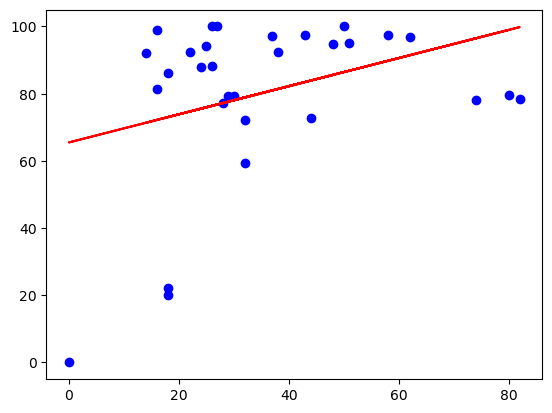

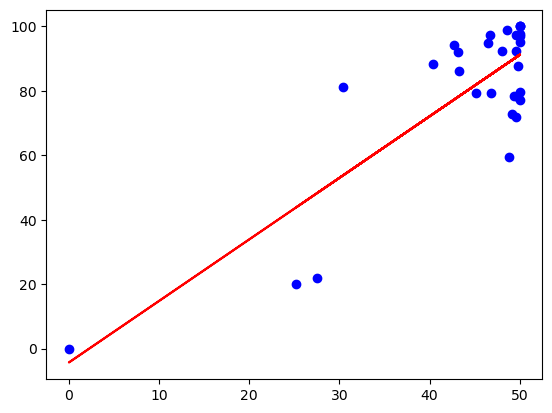

In [28]:
################################################# LINEAR REGRESSION #################################################

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)
df = activity_df
"""
dfs = {}
for name in activity_df['Vollständiger Name'].unique():
    dfs[name] = activity_df[activity_df['Vollständiger Name'] == name].reset_index(drop=True)
dfs['Student2']
"""
name_counts = df.groupby('Vollständiger Name').size().reset_index(name='activity_count')
activity_count_df = pd.DataFrame({'name': name_counts['Vollständiger Name'], 'activity_count': name_counts['activity_count']})
rating_name_df = rating_df[['Kurs gesamt (Punkte)', 'Name']].copy()
activity_count_df.rename(columns={'Vollständiger Name': 'Name'}, inplace=True)
rating_name_df.rename(columns={'Name': 'name'}, inplace=True)
merged = pd.merge(rating_name_df, activity_count_df, on='name', how='left')
merged.fillna(0.0, inplace=True)
# print(merged)
X = merged['activity_count'].values.reshape(-1, 1)
y = merged['Kurs gesamt (Punkte)'].values
reg = LinearRegression().fit(X, y)
y_hat = reg.predict(X).round(3)
mae_lin_reg = mean_absolute_error(y_hat, y).round(3)
rmse_lin_reg = mean_squared_error(y_hat, y, squared=False).round(3)
pred_lin_act = np.where(y_hat < 50, 0, 1)
proba_lin_act = y_hat/100
plt.scatter(X, y, color='blue', marker='o', label='True Points')
# plt.scatter(X, y_hat, color='red', marker='x', label='Predicted Points')
plt.plot(X, y_hat, color="red")
plt.show()

df = rating_df
X = df['Quiz gesamt (Punkte)'].values.reshape(-1, 1)
y = df['Kurs gesamt (Punkte)'].values
reg = LinearRegression().fit(X, y)
y_hat = reg.predict(X)
mae_lin_reg = mean_absolute_error(y_hat, y).round(3)
rmse_lin_reg = mean_squared_error(y_hat, y, squared=False).round(3)

plt.scatter(X, y, color='blue', marker='o', label='True Points')
# plt.scatter(X, y_hat, color='red', marker='x', label='Predicted Points')
plt.plot(X, y_hat, color="red")
activity_predict_zero_total = reg.predict([[0.0]])
activity_predict_zero_total = activity_predict_zero_total[0]

pred_lin = np.where(y_hat < 50, 0, 1)
proba_lin = y_hat/100

In [21]:
################################################# DECISION TREES #################################################

df = rating_df
# extract X,y arrays
quiz_columns = [string for string in df.columns if "Quiz" in string and "gesamt" not in string]
X = df[quiz_columns].astype(float)
y_test = df["Test: Exam Attempt 1 (Punkte)"].astype(float)
y_total = df["Kurs gesamt (Punkte)"].astype(float)
y_pass = y_total.apply(lambda x: 0 if x < 50 else 1)

mmSc = MinMaxScaler()
mmSc.fit(X)
X = mmSc.transform(X)
X = pd.DataFrame(X)
y = y_total

"""
tree_reg = DecisionTreeRegressor(max_depth=10)
tree_reg.fit(X, y)
y_pred = tree_reg.predict(X)
      
x_toPredict = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
print(tree_reg.predict([x_toPredict]))
perfect_score = [[10.0, 11.0, 10.0, 12.0, 14.0, 11.0, 7.0]]
x_toPredict = mmSc.transform(np.array(perfect_score).reshape(-1, 7))
x_toPredict = [[1,1,1,1,1,1,1]]
print(x_toPredict)
print(tree_reg.predict(x_toPredict))
print(mean_squared_error(np.array(y), y))

"""

"""
collector = []
# use leave one out, because dataset is so small
loo = LeaveOneOut()

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    tree_reg.fit(X_train, y_train)
    
    y_hat = tree_reg.predict(X_test)
    collector.append(y_hat[0])
    
y_pred = np.array(collector)    

mae_tree = mean_absolute_error(y, y_pred)
rmse_tree = mean_squared_error(y, y_pred, squared=False)
"""

# found DecisionTreeRegressor(max_depth=k), k varies, low and high

errors = []
for i in range(100):
    collector = []
    # use leave one out, because dataset is so small
    loo = LeaveOneOut()

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        tree_reg = DecisionTreeRegressor().fit(X_train, y_train)
        y_hat = tree_reg.predict(X_test)
        collector.append(y_hat[0])

    y_pred = np.array(collector)   

    errors.append({'idx': i,
                  'mae': mean_absolute_error(y, y_pred),
                  'rmse': mean_squared_error(y, y_pred, squared=False),
                  "pred": np.where(y_pred < 50, 0, 1),
                  "proba": y_pred / 100})
    
error_df = pd.DataFrame(errors).round(3)

mae_tree = error_df['mae'].iloc[error_df['mae'].idxmin()]
rmse_tree = error_df['rmse'].iloc[error_df['rmse'].idxmin()]
pred_tree = error_df['pred'].iloc[error_df['mae'].idxmax()]
proba_tree = error_df['proba'].iloc[error_df['mae'].idxmax()]

y = y_pass
errors = []
for i in range(100):
    collector = []
    collector_proba = []
    # use leave one out, because dataset is so small
    loo = LeaveOneOut()

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        tree_clas = DecisionTreeClassifier().fit(X_train, y_train)
        y_hat = tree_clas.predict(X_test)
        proba_clas = tree_clas.predict_proba(X_test)[0][1]
        collector.append(y_hat[0])
        collector_proba.append(proba_clas)

    y_pred = np.array(collector)   

    errors.append({"k": k,
                   "acc": accuracy_score(y, y_pred),
                   "bacc": balanced_accuracy_score(y, y_pred),
                   "pred": np.array(collector),
                   "proba": np.array(collector_proba)})
    
error_df = pd.DataFrame(errors).round(3)
acc_tree = error_df['acc'].iloc[error_df['acc'].idxmax()]
bacc_tree = error_df['bacc'].iloc[error_df['bacc'].idxmax()]

print("MAE: ", mae_tree)
print("RMSE: ", rmse_tree)
print("ACC: ", acc_tree)
print("bacc_tree: ", bacc_tree)

print("KNN_REG MAE: ", mae_knn_reg)
print("KNN_REG RMSE: ", rmse_knn_reg)
print("")
print("TREE_REG MAE: ", mae_tree)
print("TREE_REG RMSE: ", rmse_tree)
print("")
print("KNN_CLAS ACC: ", acc_knn_clas)
print("KNN_CLAS BACC: ", bacc_knn_clas)
print("")
print("TREE_CLAS ACC: ", acc_knn_clas)
print("TREE_CLAS BACC: ", bacc_knn_clas)
print("")
print("LIN_REG MAE: ", mae_lin_reg)
print("LIN_REG RMSE: ", rmse_lin_reg)

# ML_prediction = pd.DataFrame({"id": range(30), "pass": pred, "proba": proba})
# print(ML_prediction)

MAE:  11.402
RMSE:  14.446
ACC:  1.0
bacc_tree:  1.0
KNN_REG MAE:  13.554
KNN_REG RMSE:  18.166

TREE_REG MAE:  11.402
TREE_REG RMSE:  14.446

KNN_CLAS ACC:  0.967
KNN_CLAS BACC:  0.981

TREE_CLAS ACC:  0.967
TREE_CLAS BACC:  0.981

LIN_REG MAE:  11.691
LIN_REG RMSE:  13.813


In [22]:
################################################# ADD DECISION TREES RESULT TO RESULT DATA FRAME #################################################

result_df = rating_df
result_df = result_df.sort_values('Nr')
# pred_tree = np.where(pred_tree==1, 'Bestanden', 'Nicht bestanden')
# pred_lin = np.where(pred_lin==1, 'Bestanden', 'Nicht bestanden')
result_df['Abschluss_tree'] = pred_tree
result_df['Proba_tree'] = proba_tree
result_df['Abschluss_lin'] = pred_lin
result_df['Proba_lin'] = proba_lin
result_df['Abschluss_lin_act'] = pred_lin_act
result_df['Proba_lin_act'] = proba_lin_act

In [12]:
################################################# RANDOM VALUES #################################################
"""
import random

random_numbers = [random.randint(0, 100) for _ in range(30)]
grade_options = ["Bestanden", "Nicht bestanden"]
random_grades = [random.choice(grade_options) for _ in range(30)]

result_df = rating_df
result_df['Kursabschluss'] = random_grades
result_df['Wahrscheinlichkeit'] = random_numbers
"""

'\nimport random\n\nrandom_numbers = [random.randint(0, 100) for _ in range(30)]\ngrade_options = ["Bestanden", "Nicht bestanden"]\nrandom_grades = [random.choice(grade_options) for _ in range(30)]\n\nresult_df = rating_df\nresult_df[\'Kursabschluss\'] = random_grades\nresult_df[\'Wahrscheinlichkeit\'] = random_numbers\n'

In [23]:
data_pool.create_table(df=result_df, table_name="MachineLearning", drop_if_exists=True, force=True)

try:
    data_model.get_tables().find("MachineLearning").delete()
except:
    print("table does not exist yet")

data_model.add_table(name="MachineLearning", alias="MachineLearning")

[2023-06-05 12:22:03,301] WARNING: STRING columns are by default stored as VARCHAR(80) and therefore cut after 80 characters. You can specify a custom field length for each column using the `column_config` parameter.


[2023-06-05 12:22:03,391] INFO: Successfully created data push job with id '55fbd1e2-c287-433f-ab04-7404f6fba16a'
[2023-06-05 12:22:03,393] INFO: Add data frame as file chunks to data push job with id '55fbd1e2-c287-433f-ab04-7404f6fba16a'


  0%|          | 0/1 [00:00<?, ?it/s]

[2023-06-05 12:22:03,635] INFO: Successfully upserted file chunk to data push job with id '55fbd1e2-c287-433f-ab04-7404f6fba16a'
[2023-06-05 12:22:03,858] INFO: Successfully triggered execution for data push job with id '55fbd1e2-c287-433f-ab04-7404f6fba16a'
[2023-06-05 12:22:03,860] INFO: Wait for execution of data push job with id '55fbd1e2-c287-433f-ab04-7404f6fba16a'


0it [00:00, ?it/s]

[2023-06-05 12:22:10,074] INFO: Successfully created table 'MachineLearning' in data pool
[2023-06-05 12:22:10,223] INFO: Successfully deleted data push job with id '55fbd1e2-c287-433f-ab04-7404f6fba16a'
[2023-06-05 12:22:11,532] INFO: Successfully deleted data model table with id '96a4fe38-6c4a-4269-8818-26358ee7b758'
[2023-06-05 12:22:11,599] INFO: Successfully added data model table with id '462b7390-b1a1-4549-80d0-0b7a9ac5743e' to data model


DataModelTable(id='462b7390-b1a1-4549-80d0-0b7a9ac5743e', data_model_id='ad437bad-a13d-4f31-b247-0760c57ae3b0', name='MachineLearning', alias='MachineLearning', data_pool_id='5656d8b6-63fd-41f0-9e10-6183b71028c9')

In [24]:
data_model.reload()

[2023-06-05 12:22:11,950] INFO: Successfully triggered data model reload for data model with id 'ad437bad-a13d-4f31-b247-0760c57ae3b0'
[2023-06-05 12:22:11,952] INFO: Wait for execution of data model reload for data model with id 'ad437bad-a13d-4f31-b247-0760c57ae3b0'


0it [00:00, ?it/s]